In [1]:
%matplotlib widget

In [2]:
import numpy as np
from numpy import log, arctan2, pi, mean
from numpy.linalg import norm, solve
from scipy.special import roots_legendre
import matplotlib.pyplot as plt
from bem import assem, eval_sol
import meshio

The following function assemble the matrices from
the influence coefficients.

In [3]:
def assem(coords, elems):
    """Assembly matrices for the BEM problem

    Parameters
    ----------
    coords : ndarray, float
        Coordinates for the nodes.
    elems : ndarray, int
        Connectivity for the elements.

    Returns
    -------
    Gmat : ndarray, float
        Influence matrix for the flow.
    Fmat : ndarray, float
        Influence matrix for primary variable.
    """
    nelems = elems.shape[0]
    Gmat = np.zeros((nelems, nelems))
    Hmat = np.zeros((nelems, nelems))
    for ev_cont, elem1 in enumerate(elems):
        for col_cont, elem2 in enumerate(elems):
            pt_col = mean(coords[elem2], axis=0)
            if ev_cont == col_cont:
                L = norm(coords[elem1[1]] - coords[elem1[0]])
                Gmat[ev_cont, ev_cont] = - L/(2*pi)*(log(L/2) - 1)
                Hmat[ev_cont, ev_cont] = - 0.5
            else:
                # Gij, Hij = influence_coeff(elem1, coords, pt_col)
                Gij, Hij = influence_coeff_num(elem1, coords, pt_col)
                Gmat[ev_cont, col_cont] = Gij
                Hmat[ev_cont, col_cont] = Hij
    return Gmat, Hmat

In [4]:
def green_pot(r):
    return -0.5*np.log(r)/np.pi


def green_flow(rvec, normal):
    r = np.linalg.norm(rvec)
    return -0.5/(np.pi*r**2) * rvec.dot(normal)

The influence coefficients are computed analytically
as

In [5]:
def interp_coord(coords, npts=2):
    """Compute influence coefficients

    Parameters
    ----------
    coords : ndarray, float
        Coordinates for the nodes of the element.
    npts : int, optional
        Number of Gauss points to use.

    Returns
    -------
    pt_coords : float
        Interpolated coordinates of the point.
    jac_det : float
        Determinant of the Jacobian.
    """
    jac_det = np.linalg.norm(coords[1, :] - coords[0, :])/2
    gs_pts, gs_wts = roots_legendre(npts)
    x = 0.5 * np.outer((1 - gs_pts), coords[0, :])\
      + 0.5 * np.outer((1 + gs_pts), coords[1, :])
    return x, jac_det, gs_wts

In [6]:
def influence_coeff_num(elem, coords, pt_col):
    """Compute influence coefficients

    Parameters
    ----------
    elems : ndarray, int
        Connectivity for the element.
    coords : ndarray, float
        Coordinates for the nodes.
    pt_col : ndarray
        Coordinates of the colocation point.

    Returns
    -------
    G_coeff : float
        Influence coefficient for flows.
    H_coeff : float
        Influence coefficient for primary variable.
    """
    dcos = coords[elem[1]] - coords[elem[0]]
    dcos = dcos / norm(dcos)
    rotmat = np.array([[dcos[1], -dcos[0]],
                       [dcos[0], dcos[1]]])
    normal = rotmat @ dcos
    x, jac_det, gs_wts = interp_coord(coords[elem], npts=4)
    G = green_pot(np.linalg.norm(x - pt_col, axis=1))
    H = green_flow(x - pt_col, normal)
    G_coeff = G.dot(gs_wts) * jac_det
    H_coeff = H.dot(gs_wts) * jac_det
    return G_coeff, H_coeff

Now, let us run a simulation.

In [7]:
mesh = meshio.read("files/disk.msh")
elems = np.vstack([cells.data for cells in mesh.cells[0:4]])
bound_nodes = list(set(elems.flatten()))
coords = mesh.points[bound_nodes, :2]
x, y = coords.T
x_m, y_m = 0.5*(coords[elems[:, 0]] + coords[elems[:, 1]]).T
theta = np.arctan2(y_m, x_m)
u_boundary = 3*np.cos(6*theta)

In [8]:
Gmat, Hmat = assem(coords, elems)

In [9]:
q_boundary = solve(Gmat, Hmat.dot(u_boundary))

In [10]:
ev_coords =  mesh.points[:, :2]
ev_x, ev_y = ev_coords.T
solution = eval_sol(ev_coords, coords, elems, u_boundary, q_boundary)

[]

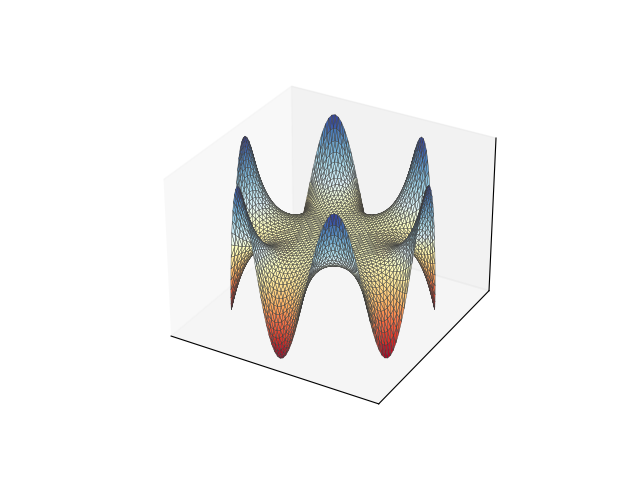

In [11]:
tris = mesh.cells[4]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(ev_x, ev_y, solution, cmap="RdYlBu", lw=0.3,
                edgecolor="#3c3c3c")
plt.xticks([])
plt.yticks([])
ax.set_zticks([])

## Analytical solution

In this case, we can check that the solution is

$$u = 3 r^6\cos(6\theta)\, .$$

In [12]:
sol_fun = lambda r, t: 3*r**6*np.cos(6*t)

In [13]:
ev_r = np.sqrt(ev_x**2 + ev_y**2)
ev_t = np.arctan2(ev_y, ev_x)

In [14]:
sol_analytic = sol_fun(ev_r, ev_t)

[]

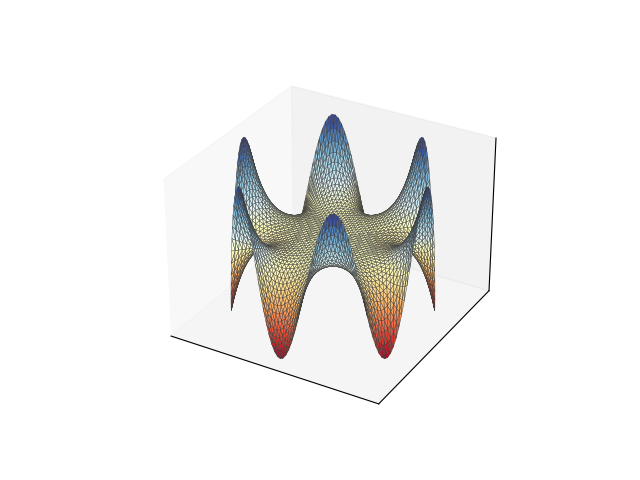

In [15]:
tris = mesh.cells[4]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(ev_x, ev_y, sol_analytic, cmap="RdYlBu", lw=0.3,
                edgecolor="#3c3c3c")
plt.xticks([])
plt.yticks([])
ax.set_zticks([])

[]

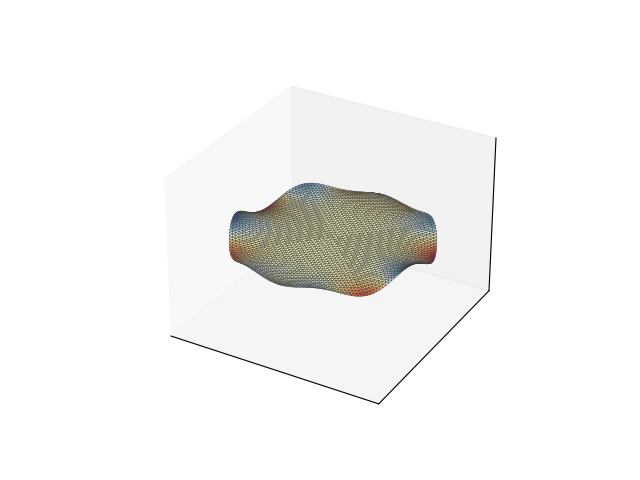

In [16]:
tris = mesh.cells[4]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(ev_x, ev_y, sol_analytic - solution,
                cmap="RdYlBu", lw=0.3,
                edgecolor="#3c3c3c")
ax.set_zlim([-3, 3])
plt.xticks([])
plt.yticks([])
ax.set_zticks([])

In [17]:
rel_error = 100*np.linalg.norm(sol_analytic - solution)/np.linalg.norm(sol_analytic)
rel_error

np.float64(7.930404672908275)